# Туториал по языковым моделям на базе RNN

In [1]:
# # библиотека для BPE токенизации
# # https://github.com/VKCOM/YouTokenToMe
!pip install youtokentome

     |████████████████████████████████| 1.7MB 4.1MB/s 


In [2]:
!pip install pandas
!pip install torch
!pip install tqdm
!pip install matplotlib

### Импортирование библиотек

In [3]:
import math
import numpy as np
import pandas as pd

import random
import json
import torch
from torch.utils.data import Dataset, DataLoader

from tqdm import tqdm

from matplotlib import pyplot as plt

import youtokentome as yttm

In [ ]:
assert torch.cuda.is_available(), 'у вас не находится гпу'

device = torch.device('cuda')

In [ ]:
print(f'Количество обучаемых параметров в сети: {count_parameters(model):,}')

Количество обучаемых параметров в сети: 7,944,192


In [ ]:
x = x.to(device)
y = y.to(device)

In [ ]:
# это специальный дропаут для реккуретных сетей
# хорошо это объясняется здесь: https://youtu.be/WLaAIYQHHMU?t=1093

class SpatialDropout(torch.nn.Dropout2d):
    
    def __init__(self, p=0.5):
        super().__init__()
        self.p = p
    
    def forward(self, x):
        x = x.unsqueeze(2)    # (N, T, 1, K)
        x = x.permute(0, 3, 2, 1)  # (N, K, 1, T)
        x = super(SpatialDropout, self).forward(x)  # (N, K, 1, T)
        x = x.permute(0, 3, 2, 1)  # (N, T, 1, K)
        x = x.squeeze(2)  # (N, T, K)
        return x

# Научились генерироваться вопросы

# Домашка №3
## Seq2Seq
### Научиться генерировать ответы по вопросу

### Вам понадобится:
1. Написать *Dataset* для задачи seq2seq
1. Реализовать модель
1. Сделать цикл обучения
1. Реализовать метод генерации ответа по вопросу с помощью вашей модели

### Примерный список того, что можно сделать:
Необязательно реализовывать все
1. Сделать модель, основанную на lstm/gru **5 баллов**
1. Сделать модель, основанную на cnn **7 баллов**
1. Сделать модель, основанную на трансформере (реализовать все слои самому) **10 баллов**
1. Добавить в rnn/cnn модель attention **5 баллов**
1. Реализовать жадное семплирование (генерацию по самому вероятному токену, как выше в языковой модели) **3 балла**
1. Реализовать beam search **5 баллов**
1. Реализовать nucleus sampling **5 баллов**
1. Добавить condition в модель **3 балла**
1. Добавить layer norm/residual в cnn или rnn модель **1 балл**
1. Реализовать аккамуляцию градиентов **1 балл**
1. Сделать телеграм бота **2 балла**

#### Дополнительные детали:  
**Сделать модель** подразумевает весь код с обучением и генерацией ответа по аналогии с языковой моделью.  
**6-й пункт:** у нас есть категория вопроса и мы можем явным образом добавить эту информацию в модель. Затем мы сможем задавать вопрос из любой категории, а отвечать таким ответом, которой больше будет соответствовать категории (которую мы сможем сами задать в модель). То есть на этапе предсказания мы задаем сети вопрос и категорию ответа, то есть в каком стиле наша сеть должна ответить. То есть должно получиться что-то такое:
```
Вопрос пользователя:
    Что мне делать с моей девушкой? она плохо себя ведет

Задаем категорию:
    Авто
Ответ модели:
    Сдайте ее в техосмотр

Задаем категорию:
    Сад и огород
Ответ модели:
    Вам нужно лучше ее поливать
```
**7-й пункт:**  
Статья: https://arxiv.org/pdf/1904.09751.pdf  
В помощь: https://huggingface.co/blog/how-to-generate

### Данные для seq2seq
***Данные*** - это файл, где каждая строка - json объект формата:
```json
{
    "question": "вопрос",
    "category": "некоторая категория вопроса",
    "responses": [
        "первый ответ на вопрос",
        "второй ответ на вопрос",
        "третий ответ на вопрос",
    ]
}
```
Количество ответов: от 1 до 5

Эти данные лучше очищены, так что советую переобучить BPE.  
Необязательно учиться на всех данных. Вы можете взять половину/четверть, если не хотите долго ждать. Так результаты будут похуже, но быстрее.

In [ ]:
import zipfile

In [ ]:
z = zipfile.ZipFile('qa_data.jsonl.zip', 'r')

In [ ]:
z.extractall()

In [ ]:
# чтобы прочитать весь файл

qa_data = list()

with open('qa_data.jsonl') as file_object:
    for line in file_object:
        qa_data.append(json.loads(line.strip()))

In [ ]:
len(qa_data)

2808811

In [ ]:
with open('for_bpe.txt', 'w', encoding='utf-8') as f:
    pass

with open('for_bpe.txt', 'a', encoding='utf-8') as f:
     for que in qa_data[:150000]:
        f.write(que['question'] + '\n')
        for response in que['responses']:
            f.write(response + '\n')
        
# параметры
vocab_size = 30_000
model_path = 'pretrained_bpe_lm.model'

yttm.BPE.train(data='for_bpe.txt', vocab_size=vocab_size, model=model_path)

tokenizer = yttm.BPE(model=model_path)

In [ ]:
# параметры
vocab_size = 30_000
model_path = 'pretrained_bpe_lm.model'

In [ ]:
# %%time
# # обучаем
# # раскомментируйте этот код, чтобы обучить bpe
yttm.BPE.train(data='for_bpe.txt', vocab_size=vocab_size, model=model_path)

In [ ]:
tokenizer = yttm.BPE(model=model_path)

In [ ]:
tokenizer.encode(['Много пушистых кошек'])

[[4, 1, 565, 7423, 6846, 6097]]

In [ ]:
categories = set()
for dialog in qa_data:
    categories.add(dialog['category'])

In [ ]:
categories

{'Авто, Мото',
 'Бизнес, Финансы',
 'Досуг, Развлечения',
 'Еда, Кулинария',
 'Животные, Растения',
 'Знакомства, Любовь, Отношения',
 'Искусство и Культура',
 'Красота и Здоровье',
 'Образование',
 'Путешествия, Туризм',
 'Работа, Карьера',
 'Семья, Дом, Дети',
 'Спорт',
 'Стиль, Мода, Звезды',
 'Философия, Непознанное'}

In [ ]:
category2id = {}
for i, category in enumerate(categories):
    category2id[category]=i
category2id  

NameError: name 'categories' is not defined

In [5]:
category2id = {'Красота и Здоровье': 0,
 'Еда, Кулинария': 1,
 'Авто, Мото': 2,
 'Досуг, Развлечения': 3,
 'Бизнес, Финансы': 4,
 'Спорт': 5,
 'Знакомства, Любовь, Отношения': 6,
 'Образование': 7,
 'Философия, Непознанное': 8,
 'Путешествия, Туризм': 9,
 'Искусство и Культура': 10,
 'Животные, Растения': 11,
 'Семья, Дом, Дети': 12,
 'Работа, Карьера': 13,
 'Стиль, Мода, Звезды': 14}

In [ ]:
#Сначала поучим модель только на ответах и классах в надежде получить адеквадные веса для категорий

In [ ]:
batch_size = 64

max_len = 32

pad_index = 0
bos_index=2
eos_index = 3

In [ ]:
#Пусть для каждой категории будет свой токен начала

In [ ]:
max_len=32
eos_index=3
bos_index=2
pad_index=0


In [ ]:
class AnsweringLanguageModelData(torch.utils.data.Dataset):
    
    def __init__(self, data, max_len, pad_index, eos_index):
        
        self.data = []
        for dialog in data:
            try:
                question = tokenizer.encode(dialog['question'])
                for response in dialog['responses']:
                    answerData = {}
                    answerData['question'] = question
                    answerData['category'] = category2id[dialog['category']]
                    answerData['response'] = tokenizer.encode(response)
                    self.data.append(answerData)
            except:
                pass
                
        
        self.max_len = max_len
        
        self.pad_index = pad_index
        self.eos_index = eos_index
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index):
        
        dialog = self.data[index]
        question = dialog['question'] + [self.eos_index] 
        x = question[:self.max_len]
        category_id = dialog['category']
        response = [vocab_size + category_id] + dialog['response'] + [self.eos_index]
        y = response[:self.max_len]
        category_id = dialog['category']
        
        
        padsX = [self.pad_index] * (self.max_len - len(x))
        padsY = [self.pad_index] * (self.max_len - len(y))
        
        x = torch.tensor(x + padsX).long()
        y = torch.tensor(y + padsY).long()
        
        return x, y, category_id

In [ ]:
batch_size=5

In [ ]:
max_len=32
pad_index=0
eos_index=3

In [ ]:
train_dataset = AnsweringLanguageModelData(qa_data[:15000], max_len, pad_index, eos_index)
train_dataloader =  torch.utils.data.DataLoader(train_dataset, batch_size=batch_size)

valid_dataset = AnsweringLanguageModelData(qa_data[-1000:], max_len, pad_index, eos_index)
valid_dataloader =  torch.utils.data.DataLoader(valid_dataset, batch_size=batch_size)

In [ ]:
demo_dataloader =  torch.utils.data.DataLoader(valid_dataset, batch_size=1)

In [1]:
class SimpleAttention(torch.nn.Module):
    
    def __init__(self, embedding_dim, is_masked=False):
        super().__init__()
        self.is_masked = is_masked
        self.linear = torch.nn.Linear(embedding_dim, embedding_dim)
        
        
    def forward(self, x):
        x = self.linear(x)
        attention_scores = torch.bmm(x.transpose(1, 2), x)
                        
        attention_scores = torch.softmax(attention_scores, 2)
        x = torch.bmm(x, attention_scores) + x
    

        return x

NameError: ignored

In [ ]:
class LstmBasedModel(torch.nn.Module):
    def __init__(self,  vocab_size, embedding_dim, seq_len, num_topics, pad_id=0, dropout=0.2):
        super().__init__()
        self.embedding_layer = torch.nn.Embedding(num_embeddings=vocab_size+num_topics, 
                                                  embedding_dim=embedding_dim,
                                                  padding_idx=pad_id)
        self.dropout = SpatialDropout(dropout)
        self.input_attention = SimpleAttention(embedding_dim)
        self.layer_norm = torch.nn.LayerNorm([seq_len, embedding_dim])
        self.lstm_understanding = torch.nn.LSTM(input_size=embedding_dim, hidden_size=embedding_dim, batch_first=True)
        
        self.lstm_generating = torch.nn.LSTM(input_size=embedding_dim, hidden_size=embedding_dim, batch_first=True)
        self.language_model_head = torch.nn.Linear(embedding_dim, vocab_size+num_topics)
        
        
    def forward(self, x):
        x = self.embedding_layer(x)
        x = self.dropout(x)
        x = self.input_attention(x)
        x = self.layer_norm(x) + x
        x = self.dropout(x)
        x, memory = self.lstm_understanding(x)
        return memory

In [ ]:
def train(model, loader, optimizer, criterion, last_n_losses=500,  verbose=True):
    progress_bar = tqdm(total=len(loader), disable=not verbose, desc='Evaluate')
    model.train()
    losses = []
    for x, y, _ in loader:
        tqdm._instances.clear()
        #x = x.cuda()
        #y = y.cuda()
        memory = model(x)
       
        answer = model.embedding_layer(y)
        generated_data, _ = model.lstm_generating(answer, memory)
        pred = model.language_model_head(generated_data)
        
        
        loss = criterion(pred.view(-1, pred.size(-1))[:-1, :], y.view(-1)[1:])
        loss.backward()
        if len(losses) % 5 == 0:
            optimizer.step()
            optimizer.zero_grad()
        
        losses.append(loss.item())

        if len(losses) % 200 == 0:
            tqdm.write('loss=' + str(np.mean(losses[-last_n_losses:])))
        
    return losses

In [ ]:
def eval(model, loader, criterion):
    losses = []
    model.eval()
    losses = []
    with torch.no_grad():
        for x, y, _ in loader:
           # x = x.cuda()
           # y = y.cuda()
            memory = model(x)
           
            answer = model.embedding_layer(y)
            generated_data, _ = model.lstm_generating(answer, memory)
            pred = model.language_model_head(generated_data)

        
            loss = criterion(pred.view(-1, pred.size(-1))[:-1, :], y.view(-1)[1:])
            losses.append(loss.item())

        
    return sum(losses)/len(losses)
        

In [ ]:
model = LstmBasedModel(vocab_size, 128, 32, len(category2id), batch_size) #последний аргумент передан по ошибке
criterion = torch.nn.CrossEntropyLoss(ignore_index=pad_index)
optimizer = torch.optim.Adam(params=model.parameters())

In [ ]:
n_epochs = 5
train_losses = []
valid_losses = []
for i in range(n_epochs):
    train_losses += train(model, train_dataloader, optimizer, criterion)
    valid_losses.append(eval(model, valid_dataloader, criterion))
    if len(valid_losses) == 1 or valid_losses[-1] < valid_losses[-2]:
        torch.save(model.state_dict(), f'best_lstm_model_state_dict.pth')  

In [ ]:
plt.figure(figsize=(14, 14))
plt.xlabel('Номер батча')
plt.ylabel('Значение функции потерь')
plt.title('Процесс обучения')
plt.plot(train_losses)

In [ ]:
plt.figure(figsize=(14, 14))
plt.xlabel('Номер батча')
plt.ylabel('Значение функции потерь')
plt.title('Процесс обучения')
plt.plot(valid_losses)

In [ ]:
model.load_state_dict(torch.load('best_lstm_model_state_dict.pth'))

<All keys matched successfully>

In [42]:
def simple_generate(lstm_based_model, x, category_id, vocab_size=30000, eos_id=3):
    lstm_based_model.eval()
    with torch.no_grad():
        answer = []
        next_token = int(category_id)+vocab_size
        memory = lstm_based_model(x)
        while next_token != eos_id and len(answer)<300:
            answer.append(next_token)
            answer_beginning =  lstm_based_model.embedding_layer(torch.unsqueeze(torch.tensor(answer),0).long())
            interpretation = lstm_based_model.language_model_head(lstm_based_model.lstm_generating(answer_beginning)[0][0,-1])
            next_token = int(torch.argmax(interpretation))
        return answer

In [ ]:
for x, y, category_id in demo_dataloader:
    x_text = tokenizer.decode(x.tolist())
    prediction = simple_generate(model, x, category_id)
    prediction_to_decode = []
    for token_id in prediction:
        if token_id < 30_000:
            prediction_to_decode.append(token_id)
        else:
            prediction_to_decode.append(2)
    generated_text = tokenizer.decode(prediction_to_decode)
    print(x_text)
    print(generated_text)
    print('___')

['какие предметы в 9 классе гиа нужно сдавать, если хочу (наверное) стать архитектором?..<EOS><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD>']
['<BOS>']
___
['откуда в этой категории столько богов, никаких свечек не хватит?<EOS><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD>']
['<BOS> на сайте авиакомпании']
___
['откуда в этой категории столько богов, никаких свечек не хватит?<EOS><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD>']
['<BOS> на сайте авиакомпании']
___
['откуда в этой категории столько богов, никаких свечек не хватит?<EOS><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD>']
['<BOS> на сайте авиакомпании']
___
['какие посоветуете принимать ванны, чтобы кожа была упругой, подтянутой?<EOS><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD>']
['<BOS> и не в моем вкусе']
___
['каки

Модель научилось отвечать на все "не знаю" и часто заканчивает ответ сразу

Посмотрим, работает ли указание темы

In [17]:
questions = ['что делать, если моя девушка плохо себя ведет', 'что подарить другу на день рождения', 'куда пойти работать']

In [ ]:
id2category={}
for i in category2id:
    id2category[category2id[i]] = i
id2category

{0: 'Красота и Здоровье',
 1: 'Еда, Кулинария',
 2: 'Авто, Мото',
 3: 'Досуг, Развлечения',
 4: 'Бизнес, Финансы',
 5: 'Спорт',
 6: 'Знакомства, Любовь, Отношения',
 7: 'Образование',
 8: 'Философия, Непознанное',
 9: 'Путешествия, Туризм',
 10: 'Искусство и Культура',
 11: 'Животные, Растения',
 12: 'Семья, Дом, Дети',
 13: 'Работа, Карьера',
 14: 'Стиль, Мода, Звезды'}

In [6]:
id2category = {0: 'Красота и Здоровье',
 1: 'Еда, Кулинария',
 2: 'Авто, Мото',
 3: 'Досуг, Развлечения',
 4: 'Бизнес, Финансы',
 5: 'Спорт',
 6: 'Знакомства, Любовь, Отношения',
 7: 'Образование',
 8: 'Философия, Непознанное',
 9: 'Путешествия, Туризм',
 10: 'Искусство и Культура',
 11: 'Животные, Растения',
 12: 'Семья, Дом, Дети',
 13: 'Работа, Карьера',
 14: 'Стиль, Мода, Звезды'}

In [18]:
demo_data = []
for question in questions:
    for i in range(len(id2category)):
        pseudo_sample = {}
        pseudo_sample['question'] = question
        pseudo_sample['responses']=['']
        pseudo_sample['category']=id2category[i]
        demo_data.append(pseudo_sample)

In [ ]:
demo_dataset = AnsweringLanguageModelData(demo_data, max_len=32, pad_index=0)
demo_dataloader =  torch.utils.data.DataLoader(demo_dataset, batch_size=1)

In [ ]:
len(demo_dataset)

45

In [ ]:
for x, y, category_id in demo_dataloader:
    x_text = tokenizer.decode(x.tolist())
    prediction = simple_generate(model, x, category_id)
    prediction_to_decode = []
    for token_id in prediction:
        if token_id < 30_000:
            prediction_to_decode.append(token_id)
        else:
            prediction_to_decode.append(2)
    generated_text = tokenizer.decode(prediction_to_decode)
    print(x_text)
    print(generated_text)
    print('___')

['<UNK>то делать, если моя девушка плохо себя ведет<EOS><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD>']
['<BOS> и не в моем вкусе']
___
['<UNK>то делать, если моя девушка плохо себя ведет<EOS><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD>']
['<BOS> а то что это не будет']
___
['<UNK>то делать, если моя девушка плохо себя ведет<EOS><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD>']
['<BOS>']
___
['<UNK>то делать, если моя девушка плохо себя ведет<EOS><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD>']
['<BOS> по имени солнце']
___
['<UNK>то делать, если моя девушка плохо себя ведет<EOS><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD>']
['<BOS> в этом году не знаю']
___
['<UNK>то делать, если моя девушка

Ответы разные, но нет и намека на тематическое деление

Попробуем запретить слишком рано предсказывать служебный симвл

Похоже, результат определяется исключительно темой, а не фразой

In [33]:
class DifferentSeqsAttention(torch.nn.Module):
    def __init__(self, embedding_dim):
        super().__init__()
        self.linear_key = torch.nn.Linear(embedding_dim, embedding_dim)
        self.linear_query = torch.nn.Linear(embedding_dim, embedding_dim)
        self.linear_value = torch.nn.Linear(embedding_dim, embedding_dim)
        
    def forward(self, x, y):
        key = self.linear_key(x)
        query = self.linear_query(y)
        value = self.linear_value(y)
        attention_scores = torch.bmm(query.transpose(1, 2), key)
        return torch.bmm(value, attention_scores)+y

Почистим данные от дубликатов

In [ ]:
already_seen_questions = set()
already_seen_answers = set()
qa_data_no_duplicates = []
for question_data in qa_data:
    if question_data['question'] not in already_seen_questions:
        already_seen_questions.add(question_data['question'])
    for response in question_data['responses']:
        if response not in already_seen_answers:
            already_seen_answers.add(response)
            qa_data_no_duplicates.append({'question': question_data['question'], 'category': question_data['category'], 'responses': [response]})

Повторим обучение токенизации без повторений

In [14]:
vocab_size = 30_000
model_path = 'pretrained_bpe_lm_no_duplicates.model'

In [ ]:
with open('for_bpe.txt', 'w', encoding='utf-8') as f:
    pass

with open('for_bpe.txt', 'a', encoding='utf-8') as f:
     for que in qa_data:
        f.write(que['question'] + '\n')
        for response in que['responses']:
            f.write(response + '\n')
        

yttm.BPE.train(data='for_bpe.txt', vocab_size=vocab_size, model=model_path)

tokenizer = yttm.BPE(model=model_path)

In [16]:
tokenizer = yttm.BPE(model=model_path)

Уберем из ответа конец предложения, пусть маркером будет начало пада. Все равно конец предсказывался как-то странно

In [19]:
class AnsweringLanguageModelData(torch.utils.data.Dataset):
    
    def __init__(self, data, max_len, pad_index=0):
        
        self.data = []
        for dialog in data:
            try:
                question = tokenizer.encode(dialog['question'])
                for response in dialog['responses']:
                    answerData = {}
                    answerData['question'] = question
                    answerData['category'] = category2id[dialog['category']]
                    answerData['response'] = tokenizer.encode(response)
                    self.data.append(answerData)
            except Exception as e:
                print(e)
                
        
        self.max_len = max_len
        
        self.pad_index = pad_index
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index):
        
        dialog = self.data[index]
        question = dialog['question']
        x = question[:self.max_len]
        category_id = dialog['category']
        response = [vocab_size + category_id] + dialog['response']
        y = response[:self.max_len]
        category_id = dialog['category']
        
        
        padsX = [self.pad_index] * (self.max_len - len(x))
        padsY = [self.pad_index] * (self.max_len - len(y))
        
        x = torch.tensor(x + padsX).long()
        y = torch.tensor(y + padsY).long()
        
        return x, y, category_id

In [ ]:
max_len = 32
batch_size = 3
pad_index = 0

In [ ]:
train_dataset = AnsweringLanguageModelData(qa_data_no_duplicates[:-5000], max_len, pad_index)
train_dataloader =  torch.utils.data.DataLoader(train_dataset, batch_size=batch_size)

valid_dataset = AnsweringLanguageModelData(qa_data_no_duplicates[-5000:], max_len, pad_index)
valid_dataloader =  torch.utils.data.DataLoader(valid_dataset, batch_size=batch_size)

In [ ]:
len(train_dataloader)

667391

In [ ]:
demo_realdata_dataloader =  torch.utils.data.DataLoader(valid_dataset, batch_size=1)

In [20]:
demo_dataset = AnsweringLanguageModelData(demo_data, max_len=32, pad_index=0)
demo_dataloader =  torch.utils.data.DataLoader(demo_dataset, batch_size=1)

In [17]:
len(demo_dataset)

45

In [ ]:
И попробуем заново обучить архитектуру, которая до чистки данных отвечала на все "я не знаю"

In [ ]:
class LstmBasedModel(torch.nn.Module):
    def __init__(self,  vocab_size, embedding_dim, seq_len, num_topics, pad_id=0, dropout=0.2):
        super().__init__()
        self.embedding_layer = torch.nn.Embedding(num_embeddings=vocab_size+num_topics, 
                                                  embedding_dim=embedding_dim,
                                                  padding_idx=pad_id)
        self.dropout = SpatialDropout(dropout)
        self.input_attention = SimpleAttention(embedding_dim)
        self.layer_norm = torch.nn.LayerNorm([seq_len, embedding_dim])
        self.lstm_understanding = torch.nn.LSTM(input_size=embedding_dim, hidden_size=embedding_dim, batch_first=True)
        
        self.lstm_generating = torch.nn.LSTM(input_size=embedding_dim, hidden_size=embedding_dim, batch_first=True)
        self.language_model_head = torch.nn.Linear(embedding_dim, vocab_size+num_topics)
        
        
    def forward(self, x):
        x = self.embedding_layer(x)
        x = self.dropout(x)
        x = self.input_attention(x)
        x = self.layer_norm(x) + x
        x = self.dropout(x)
        x, memory = self.lstm_understanding(x)
        return memory

In [ ]:
def train(model, loader, optimizer, criterion, last_n_losses=500,  verbose=True, clip=2.):
    progress_bar = tqdm(total=len(loader), disable=not verbose, desc='Evaluate')
    model.train()
    losses = []
    for x, y, _ in loader:
        tqdm._instances.clear()
        x = x.to(device)
        y = y.to(device)
        memory = model(x)
       
        answer = model.embedding_layer(y)
        generated_data, _ = model.lstm_generating(answer, memory)
        pred = model.language_model_head(generated_data)
        
        
        loss = criterion(pred.view(-1, pred.size(-1))[:-1, :], y.view(-1)[1:])
        loss.backward()
        if len(losses) % 5 == 0:
            torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
            optimizer.step()
            optimizer.zero_grad()
        
        losses.append(loss.item())

        if len(losses) % 1000 == 0:
            tqdm.write('loss=' + str(np.mean(losses[-last_n_losses:])))
        
    return losses

In [ ]:
def eval(model, loader, criterion):
    model.eval()
    losses = []
    with torch.no_grad():
        for x, y, _ in loader:
            x = x.to(device)
            y = y.to(device)
            memory = model(x)
           
            answer = model.embedding_layer(y)
            generated_data, _ = model.lstm_generating(answer, memory)
            pred = model.language_model_head(generated_data)

        
            loss = criterion(pred.view(-1, pred.size(-1))[:-1, :], y.view(-1)[1:])
            losses.append(loss.item())

        
    return sum(losses)/len(losses)

In [ ]:
model = LstmBasedModel(vocab_size, 128, 32, len(category2id)) 
model.to(device)
criterion = torch.nn.CrossEntropyLoss(ignore_index=pad_index)
optimizer = torch.optim.Adam(params=model.parameters())

In [ ]:
n_epochs = 3
#train_losses = []
#valid_losses = []
for i in range(n_epochs):
    train_losses += train(model, train_dataloader, optimizer, criterion)
    valid_losses.append(eval(model, valid_dataloader, criterion))
    if len(valid_losses) == 1 or valid_losses[-1] < valid_losses[-2]:
        torch.save(model.state_dict(), f'best_no_duplicates_data_lstm_model_state_dict.pth')  

In [ ]:
plt.xlabel('Номер батча')
plt.ylabel('Значение функции потерь')
plt.title('Процесс обучения')
plt.plot(train_losses)

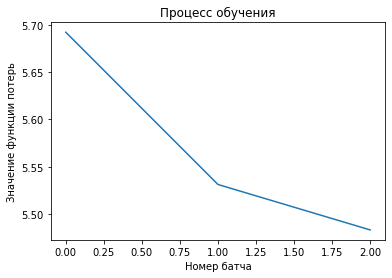

In [ ]:
plt.xlabel('Номер батча')
plt.ylabel('Значение функции потерь')
plt.title('Процесс обучения')
plt.plot(valid_losses)

In [ ]:
model.to('cpu')

LstmBasedModel(
  (embedding_layer): Embedding(30015, 128, padding_idx=0)
  (dropout): SpatialDropout(p=0.2, inplace=False)
  (input_attention): SimpleAttention(
    (linear): Linear(in_features=128, out_features=128, bias=True)
  )
  (layer_norm): LayerNorm((32, 128), eps=1e-05, elementwise_affine=True)
  (lstm_understanding): LSTM(128, 128, batch_first=True)
  (lstm_generating): LSTM(128, 128, batch_first=True)
  (language_model_head): Linear(in_features=128, out_features=30015, bias=True)
)

In [ ]:
counter = 0
for x, y, category_id in demo_realdata_dataloader:
    x_text = tokenizer.decode(x.tolist())
    prediction = simple_generate(model, x, category_id)
    prediction_to_decode = []
    for token_id in prediction:
        if token_id < 30_000:
            prediction_to_decode.append(token_id)
        else:
            prediction_to_decode.append(2)
    generated_text = tokenizer.decode(prediction_to_decode)
    print(x_text)
    print(generated_text)
    print('___')
    counter +=1
    if counter == 200:
        break

['чувагъ жгедъ! (не для слабонервных) (только фанам слэера)<PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD>']
['<BOS>ο<BOS><BOS><BOS><BOS><BOS><BOS><BOS><BOS><BOS><BOS><BOS><BOS><BOS><BOS><BOS><BOS><BOS><BOS><BOS><BOS><BOS><BOS><BOS><BOS><BOS><BOS><BOS><BOS><BOS><BOS><BOS><BOS><BOS><BOS><BOS><BOS><BOS><BOS><BOS><BOS><BOS><BOS><BOS><BOS><BOS><BOS><BOS><BOS><BOS><BOS><BOS><BOS><BOS><BOS><BOS><BOS><BOS><BOS><BOS><BOS><BOS><BOS><BOS><BOS><BOS><BOS><BOS><BOS><BOS><BOS><BOS><BOS><BOS><BOS><BOS><BOS><BOS><BOS><BOS><BOS><BOS><BOS><BOS><BOS><BOS><BOS><BOS><BOS><BOS><BOS><BOS><BOS><BOS><BOS><BOS><BOS><BOS><BOS><BOS><BOS><BOS><BOS><BOS><BOS><BOS><BOS><BOS><BOS><BOS><BOS><BOS><BOS><BOS><BOS><BOS><BOS><BOS><BOS><BOS><BOS><BOS><BOS><BOS><BOS><BOS><BOS><BOS><BOS><BOS><BOS><BOS><BOS><BOS><BOS><BOS><BOS><BOS><BOS><BOS><BOS><BOS><BOS><BOS><BOS><BOS><BOS><BOS><BOS><BOS><BOS><BOS><BOS><BOS><BOS><BOS><BOS><BOS><BOS><BOS><BOS><BOS><BOS><BOS><BOS><BOS><BOS><BOS><BOS><BOS><BOS><BOS><BOS><BOS><BOS><BOS>

KeyboardInterrupt: 

In [ ]:
#по-прежнему надо отдалять появление служебных символов

In [ ]:
for x, y, category_id in demo_dataloader:
    x_text = tokenizer.decode(x.tolist())
    prediction = generate_with_restrictions(model, x, category_id)
    prediction_to_decode = []
    for token_id in prediction:
        if token_id < 30_000:
            prediction_to_decode.append(token_id)
        else:
            prediction_to_decode.append(2)
    generated_text = tokenizer.decode(prediction_to_decode)
    print(x_text)
    print(generated_text)
    print('___')

['<UNK>то делать, если моя девушка плохо себя ведет<PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD>']
['<BOS>стройство обществознаемую¦ договорулансинешьix) удачи!<BOS><BOS><BOS><BOS><BOS><BOS><BOS><BOS><BOS><BOS><BOS><BOS><BOS><BOS><BOS><BOS><BOS><BOS><BOS><BOS><BOS><BOS><BOS><BOS><BOS><BOS><BOS><BOS><BOS><BOS><BOS><BOS><BOS><BOS><BOS><BOS><BOS><BOS><BOS><BOS><BOS><BOS><BOS><BOS><BOS><BOS><BOS><BOS><BOS><BOS><BOS><BOS><BOS><BOS><BOS><BOS><BOS><BOS><BOS><BOS><BOS><BOS><BOS><BOS><BOS><BOS><BOS><BOS><BOS><BOS><BOS><BOS><BOS><BOS><BOS><BOS><BOS><BOS><BOS><BOS><BOS><BOS><BOS><BOS><BOS><BOS><BOS><BOS><BOS><BOS><BOS><BOS><BOS><BOS><BOS><BOS><BOS><BOS><BOS><BOS><BOS><BOS><BOS><BOS><BOS><BOS><BOS><BOS><BOS><BOS><BOS><BOS><BOS><BOS><BOS><BOS><BOS><BOS><BOS><BOS><BOS><BOS><BOS><BOS><BOS><BOS><BOS><BOS><BOS><BOS><BOS><BOS><BOS><BOS><BOS><BOS><BOS><BOS><BOS><BOS><BOS><BOS><BOS><BOS><BOS><BOS><BOS><BOS><BOS><BOS><BOS><BOS><BOS><BOS><BOS>

Лучше не стало: модель заучила по ответу для темы

Попробуем на очищенных данных обучить модель с аттеншин

In [34]:
class LstmBasedModel(torch.nn.Module):
    def __init__(self,  vocab_size, embedding_dim, seq_len, num_topics, pad_id=0, dropout=0.2):
        super().__init__()
        self.embedding_layer = torch.nn.Embedding(num_embeddings=vocab_size+num_topics, 
                                                  embedding_dim=embedding_dim,
                                                  padding_idx=pad_id)
        self.dropout = SpatialDropout(dropout)
        self.input_attention = SimpleAttention(embedding_dim)
        self.layer_norm = torch.nn.LayerNorm([seq_len, embedding_dim])
        self.lstm_understanding = torch.nn.LSTM(input_size=embedding_dim, hidden_size=embedding_dim, batch_first=True)
        
        self.generating_attention = DifferentSeqsAttention(embedding_dim)
        self.lstm_generating = torch.nn.LSTM(input_size=embedding_dim, hidden_size=embedding_dim, batch_first=True)
        self.language_model_head = torch.nn.Linear(embedding_dim, vocab_size+num_topics)
        self.embedding_layer.weight = self.language_model_head.weight
        
        
    def forward(self, x):
        x = self.embedding_layer(x)
        x_embeddings = x
        x = self.dropout(x)
        x = self.input_attention(x)
        x = self.layer_norm(x) + x
        x = self.dropout(x)
        x, memory = self.lstm_understanding(x)
        return x_embeddings, memory

In [35]:
model = LstmBasedModel(vocab_size, 128, 32, len(category2id)) 
model.to(device)
criterion = torch.nn.CrossEntropyLoss(ignore_index=pad_index)
optimizer = torch.optim.Adam(params=model.parameters())

In [ ]:
def train(model, loader, optimizer, criterion, last_n_losses=500,  verbose=True, clip=2.):
    progress_bar = tqdm(total=len(loader), disable=not verbose, desc='Evaluate')
    model.train()
    losses = []
    for x, y, _ in loader:
        tqdm._instances.clear()
        x = x.to(device)
        y = y.to(device)
        question_embeddings, memory = model(x)
       
        answer = model.embedding_layer(y)
        answer = model.generating_attention(question_embeddings, answer)
        generated_data, _ = model.lstm_generating(answer, memory)
        pred = model.language_model_head(generated_data)
        
        
        loss = criterion(pred.view(-1, pred.size(-1))[:-1, :], y.view(-1)[1:])
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        if len(losses) % 5 == 0:
            torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
            optimizer.step()
            optimizer.zero_grad()
        
        losses.append(loss.item())

        #if len(losses) % 1000 == 0:
        #    tqdm.write('loss=' + str(np.mean(losses[-last_n_losses:])))
        
    return losses

In [ ]:
def eval(model, loader, criterion):
    losses = []
    model.eval()
    losses = []
    with torch.no_grad():
        for x, y, _ in loader:
            x = x.to(device)
            y = y.to(device)
            question_embeddings, memory = model(x)
           
            answer = model.embedding_layer(y)
            answer = model.generating_attention(question_embeddings, answer)
            generated_data, _ = model.lstm_generating(answer, memory)
            pred = model.language_model_head(generated_data)

        
            loss = criterion(pred.view(-1, pred.size(-1))[:-1, :], y.view(-1)[1:])
            losses.append(loss.item())

        
    return sum(losses)/len(losses)

In [ ]:
n_epochs = 5
train_losses = []
valid_losses = []
for i in range(n_epochs):
    train_losses += train(model, train_dataloader, optimizer, criterion)
    valid_losses.append(eval(model, valid_dataloader, criterion))
    if len(valid_losses) == 1 or valid_losses[-1] < valid_losses[-2]:
        torch.save(model.state_dict(), f'best_no_duplicates_attention_lstm_model_state_dict.pth')  

Evaluate:   0%|          | 0/242293 [1:39:09<?, ?it/s]


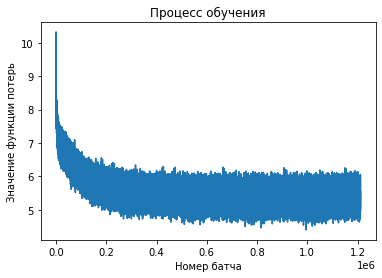

In [ ]:
plt.xlabel('Номер батча')
plt.ylabel('Значение функции потерь')
plt.title('Процесс обучения')
plt.plot(train_losses)

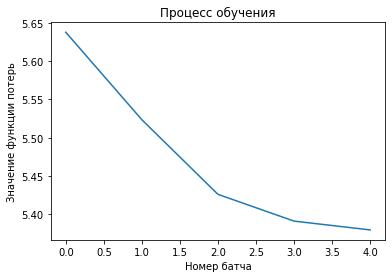

In [ ]:
plt.xlabel('Номер батча')
plt.ylabel('Значение функции потерь')
plt.title('Процесс обучения')
plt.plot(valid_losses)

In [ ]:
def generate_attention_with_restrictions(lstm_based_model, question, category_id, vocab_size=30000, eos_id=3, seq_len=32, min_answer_len=10, num_categories=15):
    lstm_based_model.eval()
    tech_poses = [0, 1, 2, 3]
    for i in range(num_categories):
        tech_poses.append(vocab_size+i)
    with torch.no_grad():
        answer = []
        next_token = int(category_id)+vocab_size
        question_embeddings, memory = lstm_based_model(question)
        while next_token != eos_id and len(answer)<seq_len:
            answer.append(next_token)
            answer_beginning =  lstm_based_model.embedding_layer(torch.unsqueeze(torch.tensor(answer),0))
            attention = lstm_based_model.generating_attention
            x = question_embeddings
            y = answer_beginning
            key = attention.linear_key(x)
            query = attention.linear_query(y)
            real_data_len = query.shape[2]
            if query.shape[1] < key.shape[1]:
                query = torch.cat((query, torch.ones(query.shape[0], key.shape[1]-query.shape[1], query.shape[2])*0), 1)
            value = attention.linear_value(y)
            attention_scores = torch.bmm(query.transpose(1, 2), key)
            #attention_scores[:, :, real_data_len:] *= 0
            answer_beginning = torch.bmm(value, attention_scores) + y
            interpretation = model.language_model_head(model.lstm_generating(answer_beginning)[0][0,len(answer)-1])
            if len(answer)<min_answer_len:
                for tech_pos in tech_poses:
                    interpretation[tech_pos] = -math.inf
                interpretation[next_token]=-math.inf
            next_token = int(torch.argmax(interpretation))
    return answer

In [ ]:
for x, y, category_id in demo_dataloader:
    x_text = tokenizer.decode(x.tolist())
    prediction = generate_attention_with_restrictions(model, x, category_id)
    prediction_to_decode = []
    for token_id in prediction:
        if token_id < 30_000:
            prediction_to_decode.append(token_id)
        else:
            prediction_to_decode.append(2)
    generated_text = tokenizer.decode(prediction_to_decode)
    print(x_text)
    print(generated_text)
    print('___')

['что делать, если моя девушка плохо себя ведет<PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD>']
['<BOS>ертку,продустенвые же свои. сою<BOS><BOS><BOS><BOS><BOS><BOS><BOS><BOS><BOS><BOS><BOS><BOS><BOS><BOS><BOS><BOS><BOS><BOS><BOS><BOS><BOS><BOS>']
___
['что делать, если моя девушка плохо себя ведет<PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD>']
['<BOS>продурованные учрезом. счет. орифркните и<BOS><BOS><BOS><BOS><BOS><BOS><BOS><BOS><BOS><BOS><BOS><BOS><BOS><BOS><BOS><BOS><BOS><BOS><BOS><BOS><BOS><BOS>']
___
['что делать, если моя девушка плохо себя ведет<PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD>']
['<BOS>мысление.-три и копеец. торговли - платит<BOS><BOS><BOS><BOS><BOS><BOS><BOS><BOS><BOS><BOS><BOS><BOS><BOS><BOS><BOS><BOS><BOS><BOS><BOS><BOS><BOS><BOS>']
___
['что

In [ ]:
Видны очень слабые вариации ответа внутри темы ("ертку.-три не стоимоду,совые и стоимо" не совсем совпалает с "ертку.-три не стоимоду,совые!ские")

Очевидно, что мне это не поможет, но все равно попробую реализовать beam search

In [ ]:
def beam_search_attention_with_restrictions(lstm_based_model, question, category_id, vocab_size=30000, eos_id=3, seq_len=32, min_answer_len=10, num_categories=15, n_best=3):
        lstm_based_model.eval()
        tech_poses = [0, 1, 2, 3]
        for i in range(num_categories):
            tech_poses.append(vocab_size+i)
        with torch.no_grad():
            next_token = int(category_id)+vocab_size
            best_answers = []
            best_answers.append({'answer': [next_token], 'probability': 1})
            counter = 0
            all_answers_are_finished = False
            question_embeddings, memory = lstm_based_model(question)
            while not all_answers_are_finished and counter < seq_len:
                counter += 1
                current_step_best_options = []
                for answer_data in best_answers:
                    answer = answer_data['answer']
                    
                    answer_beginning =  lstm_based_model.embedding_layer(torch.unsqueeze(torch.tensor(answer),0))
                    attention = lstm_based_model.generating_attention
                    x = question_embeddings
                    y = answer_beginning
                    key = attention.linear_key(x)
                    query = attention.linear_query(y)
                    real_data_len = query.shape[2]
                    if query.shape[1] < key.shape[1]:
                        query = torch.cat((query, torch.ones(query.shape[0], key.shape[1]-query.shape[1], query.shape[2])*0), 1)
                    value = attention.linear_value(y)
                    attention_scores = torch.bmm(query.transpose(1, 2), key)
                    answer_beginning = torch.bmm(value, attention_scores) + y
                    interpretation = model.language_model_head(model.lstm_generating(answer_beginning)[0][0,len(answer)-1])
                    if len(answer)<min_answer_len:
                        for tech_pos in tech_poses:
                            interpretation[tech_pos] = -math.inf
                    interpretation = torch.softmax(interpretation, axis=0)
                    
                    for i in range(n_best):
                        next_token = torch.argmax(interpretation)
                        next_token_probability = interpretation[next_token]
                        seq_probability = answer_data['probability']*next_token_probability
                        seq = answer + [next_token]
                        current_step_best_options.append({'answer': seq, 'probability':seq_probability})
                        interpretation[next_token] = -math.inf
                if len(current_step_best_options) > n_best:
                    best_answers = sorted(current_step_best_options, key = lambda x: x['probability'], reverse=True)[:n_best]
                else:
                    best_answers = current_step_best_options
                    
                if all([answer_data['answer'][-1] in tech_poses for answer_data in best_answers]):
                    all_answers_are_finished = True
        return best_answers

In [ ]:
for x, y, category_id in demo_dataloader:
    x_text = tokenizer.decode(x.tolist())
    print(x_text)
    prediction = beam_search_attention_with_restrictions(model, x, category_id)
    for i, answer_data in enumerate(prediction):
        print(i+1)
        prediction_to_decode = []
        for token_id in answer_data['answer']:
            if token_id < 30_000:
                prediction_to_decode.append(token_id)
            else:
                prediction_to_decode.append(2)
            generated_text = tokenizer.decode(prediction_to_decode)
        print(generated_text)
    print('___')

['что делать, если моя девушка плохо себя ведет<PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD>']
1
['<BOS>фициционительские же из того что конститу<BOS>']
2
['<BOS>фициционительские же из того что конститу<BOS>']
3
['<BOS>фициционительские же из того ,что банк<BOS>']
___
['что делать, если моя девушка плохо себя ведет<PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD>']
1
['<BOS>продуционноепродурованные экскурсированный. карту них<BOS>']
2
['<BOS>продуционноепродурованные экскурсированный. карту нее<BOS>']
3
['<BOS>продуционноепродурованные экскурсированный. карту на<BOS>']
___
['что делать, если моя девушка плохо себя ведет<PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD>']
1
['<BOS>мобитор.рд ориф жеэйните, банкомат же<BOS>']
2
['<BOS>мобитор.рд ориф жеэйните, банкомат же<B

In [ ]:
Лучшие варианты в большинстве случаев не совпадают с тем, что было без учета второй и третьей гипотезы

Варианты обычно похожие, но есть вариации. Стало больше различий между разными вопросами
1
['<BOS>союг,продучное недумысь. банкомат же<BOS>']
2
['<BOS>союг,продучное недумысь. форекса.<BOS>']
Совпадающие варианты в одной опции возникают, потому что бывают разные BOS
Как правило, в результате все равно побеждает одно начало, а различия начинаются ближе к концу

Реализую nucleus sampling

In [ ]:
def nucleus_sampling_attention(lstm_based_model, question, category_id, vocab_size=30000, eos_id=3, seq_len=32, num_categories=15, num_candidates = 1000):
    if vocab_size + num_categories < num_candidates:
        num_candidates = vocab_size + num_categories
    lstm_based_model.eval()
    tech_poses = [0, 1, 2, 3]
    for i in range(num_categories):
        tech_poses.append(vocab_size+i)
    with torch.no_grad():
        answer = []
        next_token = int(category_id)+vocab_size
        question_embeddings, memory = lstm_based_model(question)
        while len(answer)<seq_len:
            answer.append(next_token)
            answer_beginning =  lstm_based_model.embedding_layer(torch.unsqueeze(torch.tensor(answer),0))
            attention = lstm_based_model.generating_attention
            x = question_embeddings
            y = answer_beginning
            key = attention.linear_key(x)
            query = attention.linear_query(y)
            real_data_len = query.shape[2]
            if query.shape[1] < key.shape[1]:
                query = torch.cat((query, torch.ones(query.shape[0], key.shape[1]-query.shape[1], query.shape[2])*0), 1)
            value = attention.linear_value(y)
            attention_scores = torch.bmm(query.transpose(1, 2), key)
            #attention_scores[:, :, real_data_len:] *= 0
            answer_beginning = torch.bmm(value, attention_scores) + y
            interpretation = model.language_model_head(model.lstm_generating(answer_beginning)[0][0,len(answer)-1])
            if num_candidates < interpretation.shape[0]:
                sorted_interpretation_indeces = torch.sort(interpretation).indices
                for indec in sorted_interpretation_indeces[:-num_candidates]:
                    interpretation[indec] = -math.inf
            probabilities = torch.softmax(interpretation, axis=0)
            next_token = int(torch.multinomial(probabilities, 1))
    return answer

In [ ]:
for x, y, category_id in demo_dataloader:
    x_text = tokenizer.decode(x.tolist())
    prediction = nucleus_sampling_attention(model, x, category_id)
    prediction_to_decode = []
    for token_id in prediction:
        if token_id < 30_000:
            prediction_to_decode.append(token_id)
        else:
            prediction_to_decode.append(2)
    generated_text = tokenizer.decode(prediction_to_decode)
    print(x_text)
    print(generated_text)
    print('___')

['что делать, если моя девушка плохо себя ведет<PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD>']
['<BOS> комбинатинг<BOS><BOS><BOS><BOS><BOS><BOS><BOS><BOS><BOS><BOS><BOS><BOS><BOS><BOS><BOS><BOS><BOS><BOS><BOS><BOS><BOS><BOS><BOS><BOS><BOS><BOS><BOS><BOS><BOS>']
___
['что делать, если моя девушка плохо себя ведет<PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD>']
['<BOS>продутор.<BOS><BOS><BOS><BOS><BOS><BOS><BOS><BOS><BOS><BOS><BOS><BOS><BOS><BOS><BOS><BOS><BOS><BOS><BOS><BOS><BOS><BOS><BOS><BOS><BOS><BOS><BOS><BOS><BOS>']
___
['что делать, если моя девушка плохо себя ведет<PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD>']
['<BOS> золотых<BOS><BOS><BOS><BOS><BOS><BOS><BOS><BOS><BOS><BOS><BOS><BOS><BOS><BOS><BOS><BOS><BOS><BOS><BOS><BOS><BOS><BOS><BOS><BOS><BOS><BOS><BOS><

In [ ]:
кажется, метод не спасает от необходимости запрещать заканчивать слишком рано

In [ ]:
def nucleus_sampling_attention_with_restrictions(lstm_based_model, question, category_id, vocab_size=30000, eos_id=3, seq_len=32, num_categories=15, num_candidates = 1000, min_answer_len=10):
    tech_poses = [0, 1, 2, 3]
    for i in range(num_categories):
        tech_poses.append(vocab_size+i)
    if vocab_size + num_categories < num_candidates:
        num_candidates = vocab_size + num_categories
    lstm_based_model.eval()
    tech_poses = [0, 1, 2, 3]
    for i in range(num_categories):
        tech_poses.append(vocab_size+i)
    with torch.no_grad():
        answer = []
        next_token = int(category_id)+vocab_size
        question_embeddings, memory = lstm_based_model(question)
        while len(answer)<seq_len:
            answer.append(next_token)
            answer_beginning =  lstm_based_model.embedding_layer(torch.unsqueeze(torch.tensor(answer),0))
            attention = lstm_based_model.generating_attention
            x = question_embeddings
            y = answer_beginning
            key = attention.linear_key(x)
            query = attention.linear_query(y)
            real_data_len = query.shape[2]
            if query.shape[1] < key.shape[1]:
                query = torch.cat((query, torch.ones(query.shape[0], key.shape[1]-query.shape[1], query.shape[2])*0), 1)
            value = attention.linear_value(y)
            attention_scores = torch.bmm(query.transpose(1, 2), key)
            #attention_scores[:, :, real_data_len:] *= 0
            answer_beginning = torch.bmm(value, attention_scores) + y
            interpretation = model.language_model_head(model.lstm_generating(answer_beginning)[0][0,len(answer)-1])
            if len(answer)<min_answer_len:
                for tech_pos in tech_poses:
                    interpretation[tech_pos] = -math.inf
            if num_candidates < interpretation.shape[0]:
                sorted_interpretation_indeces = torch.sort(interpretation).indices
                for indec in sorted_interpretation_indeces[:-num_candidates]:
                    interpretation[indec] = -math.inf
            probabilities = torch.softmax(interpretation, axis=0)
            next_token = int(torch.multinomial(probabilities, 1))
    return answer

In [ ]:
for x, y, category_id in demo_dataloader:
    x_text = tokenizer.decode(x.tolist())
    prediction = nucleus_sampling_attention_with_restrictions(model, x, category_id)
    prediction_to_decode = []
    for token_id in prediction:
        if token_id < 30_000:
            prediction_to_decode.append(token_id)
        else:
            prediction_to_decode.append(2)
    generated_text = tokenizer.decode(prediction_to_decode)
    print(x_text)
    print(generated_text)
    print('___')

['что делать, если моя девушка плохо себя ведет<PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD>']
['<BOS>тернаторку, менеджемены трудовой не лада.<BOS><BOS><BOS><BOS><BOS><BOS><BOS><BOS><BOS><BOS><BOS><BOS><BOS><BOS><BOS><BOS><BOS><BOS><BOS><BOS><BOS><BOS>']
___
['что делать, если моя девушка плохо себя ведет<PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD>']
['<BOS> харьялактиян вам вообще-берите здоровь<BOS><BOS><BOS><BOS><BOS><BOS><BOS><BOS><BOS><BOS><BOS><BOS><BOS><BOS><BOS><BOS><BOS><BOS><BOS><BOS><BOS><BOS>']
___
['что делать, если моя девушка плохо себя ведет<PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD>']
['<BOS>бицию, тему. канцелевскую запату, мышелов<BOS><BOS><BOS><BOS><BOS><BOS><BOS><BOS><BOS><BOS><BOS><BOS><BOS><BOS><BOS><BOS><BOS><BOS><BOS><BOS><BOS><BOS>']
_

Есть очень адекватные примеры
['что подарить другу на день рождения<PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD>']
['<BOS> собственном всем случае купить систему и все? бер<BOS><BOS><BOS><BOS><BOS><BOS><BOS><BOS><BOS><BOS><BOS><BOS><BOS><BOS><BOS><BOS><BOS><BOS><BOS><BOS><BOS><BOS>']


А теперь попытаюсь собрать трансформер

In [7]:
class SelfAttentionHead(torch.nn.Module):
    def __init__(self, embedding_dim, is_masked=False):
        super().__init__()
        self.is_masked = is_masked
        self.linear_key = torch.nn.Linear(embedding_dim, embedding_dim)
        self.linear_query = torch.nn.Linear(embedding_dim, embedding_dim)
        self.linear_value = torch.nn.Linear(embedding_dim, embedding_dim)
        
    def forward(self, x):
        key = self.linear_key(x)
        query = self.linear_query(x)
        value = self.linear_value(x)
        attention_scores = torch.bmm(query.transpose(1, 2), key)
        if self.is_masked:
            for batch in attention_scores:
                for vector_id, vector in enumerate(batch):
                    for neighbour_id, neighbour_score in enumerate(vector):
                        if neighbour_id > vector_id:
                            neighbour_score = -math.inf
        attention_scores = torch.softmax(attention_scores, axis=2)
        x = torch.bmm(x, attention_scores)
        return x 

In [8]:
class MultyHeadSelfAttention(torch.nn.Module):
    def __init__(self, embedding_dim, num_heads=3, is_masked=False):
        super().__init__()
        self.attention_heads = [SelfAttentionHead(embedding_dim, is_masked) for i in range(num_heads)]
        self.linear = torch.nn.Linear(embedding_dim*num_heads, embedding_dim)
        
    def forward(self, x):
        attention_heads_output = [attention_head(x) for attention_head in self.attention_heads]
        concatenated_output = torch.cat(tuple(attention_heads_output), dim=2)
        x = self.linear(concatenated_output) + x
        return x
        
        

In [9]:
class AttentionHead(torch.nn.Module):
    def __init__(self, embedding_dim, is_masked=False):
        super().__init__()
        self.is_masked = is_masked
        self.linear_key = torch.nn.Linear(embedding_dim, embedding_dim)
        self.linear_query = torch.nn.Linear(embedding_dim, embedding_dim)
        self.linear_value = torch.nn.Linear(embedding_dim, embedding_dim)
        
    def forward(self, x, y):
        key = self.linear_key(y)
        query = self.linear_query(x)
        value = self.linear_value(x)
        attention_scores = torch.bmm(query.transpose(1, 2), key)
        attention_scores = torch.softmax(attention_scores, axis=2)
        x = torch.bmm(x, attention_scores)
        return x 
        
    

In [10]:
class MultyHeadAttention(torch.nn.Module):
    def __init__(self, embedding_dim, num_heads=3, is_masked=False):
        super().__init__()
        self.attention_heads = [AttentionHead(embedding_dim) for i in range(num_heads)]
        self.linear = torch.nn.Linear(embedding_dim*num_heads, embedding_dim)
        
    def forward(self, x, y):
        attention_heads_output = [attention_head(x, y) for attention_head in self.attention_heads]
        concatenated_output = torch.cat(tuple(attention_heads_output), dim=2)
        x = self.linear(concatenated_output) + x
        return x

In [11]:
class FeedForward(torch.nn.Module):
    def __init__(self, input_dim, middle_dim=None, iterations=1):
        super().__init__()
        self.iterations = iterations
        if middle_dim == None:
            middle_dim = input_dim*3
        self.linear1 = torch.nn.Linear(input_dim, middle_dim)
        self.linear2 = torch.nn.Linear(middle_dim, input_dim)
        
    def forward(self, x):
        for i in range(self.iterations):
            x = self.linear2(self.linear1(x)) + x
        return x

In [12]:
class MyTransformer(torch.nn.Module):
    def __init__(self, vocab_size, embedding_dim, seq_len, num_topics, pad_id=0, dropout=0.1, weight_tying=True):
        super().__init__()
        self.layer_norm = torch.nn.LayerNorm([seq_len, embedding_dim])
        self.dropout = SpatialDropout(dropout)
        self.embedding_layer = torch.nn.Embedding(num_embeddings=vocab_size, 
                                                  embedding_dim=embedding_dim,
                                                  padding_idx=pad_id)
        self.x_positional_embedding = torch.nn.Embedding(num_embeddings=seq_len, embedding_dim=embedding_dim)
        self.y_positional_embedding = torch.nn.Embedding(num_embeddings=seq_len, embedding_dim=embedding_dim)
        self.positions = torch.arange(0, seq_len)
        
        self.encoder_attention = MultyHeadSelfAttention(embedding_dim)
        self.encoder_feed_forward = FeedForward(embedding_dim)
        
        self.prepare_y_attention = MultyHeadSelfAttention(embedding_dim, is_masked=True)
        self.prepare_y_feed_forward = FeedForward(embedding_dim)
        
        self.decoder_attention = MultyHeadAttention(embedding_dim)
        self.decoder_feed_forward = FeedForward(embedding_dim)
        
        self.language_model_head = torch.nn.Linear(embedding_dim, vocab_size+num_topics)
        if weight_tying:
            self.embedding_layer.weight = self.language_model_head.weight
     
        
        
    def forward(self, x, y):
        pos_emb=self.x_positional_embedding(self.positions)
        x_embeddigs = self.embedding_layer(x)
        x = x_embeddigs+pos_emb
        x = self.dropout(x)
        x = self.encoder_attention(x)
        x = self.dropout(x)
        x = self.layer_norm(x)
        x = self.encoder_feed_forward(x)
        x = self.dropout(x)
        x = self.layer_norm(x)
        
        y = self.prepare_y(y)
        
        x = self.decoder_attention(x, y)
        x = self.dropout(x)
        x = self.layer_norm(x)
        x = self.decoder_feed_forward(x)
        x = self.dropout(x)
        
        x = self.language_model_head(x)
        return x
    
    def prepare_y(self, y):
        pos_emb=self.y_positional_embedding(self.positions) 
        y_embeddings = self.embedding_layer(y)
        y = y_embeddings+pos_emb
        y = self.dropout(y)
        y= self.prepare_y_attention(y)
        y = self.dropout(y)
        y = self.layer_norm(y)
        y = self.prepare_y_feed_forward(y)
        y = self.dropout(y)
        y = self.layer_norm(y)
        return y
        

In [21]:
transformer = MyTransformer(vocab_size, 128, 32, len(category2id)) 
transformer.to(device)
criterion = torch.nn.CrossEntropyLoss(ignore_index=pad_index)
optimizer = torch.optim.Adam(params=transformer.parameters())

In [ ]:
def train(transformer, loader, optimizer, criterion, last_n_losses=500,  verbose=True):
    #progress_bar = tqdm(total=len(loader), disable=not verbose, desc='Evaluate')
    transformer.train()
    losses = []
    for x, y, _ in loader:
        #x = x.to(device)
        #y = y.to(device)
        pred = transformer(x, y)
        
        loss = criterion(pred.view(-1, pred.size(-1))[:-1, :], y.view(-1)[1:])
        loss.backward()
        if len(losses) % 20 == 0:
            optimizer.step()
            optimizer.zero_grad()
        
        losses.append(loss.item())

    return losses

In [ ]:
def eval(transformer, loader, criterion):
    losses = []
    transformer.eval()
    losses = []
    with torch.no_grad():
        for x, y, _ in loader:
            x = x.to(device)
            y = y.to(device)
            pred = transformer(x, y)
            loss = criterion(pred.view(-1, pred.size(-1))[:-1, :], y.view(-1)[1:])
            losses.append(loss)

    return sum(losses)/len(losses)

In [ ]:
n_epochs = 1
train_losses = []
valid_losses = []
for i in range(n_epochs):
    train_losses += train(transformer, train_dataloader, optimizer, criterion)
    valid_losses.append(eval(transformer, valid_dataloader, criterion))
    if len(valid_losses) == 1 or valid_losses[-1] < valid_losses[-2]:
        torch.save(model.state_dict(), f'my_transformer_state_dict.pth')  

Трансформер не захотел полностью жить на гпу, обучала на цпу меньше эпохи

In [22]:
files.upload()

Saving my_transformer_state_dict.pth to my_transformer_state_dict.pth


In [28]:
transformer.load_state_dict(torch.load('my_transformer_state_dict.pth'))

<All keys matched successfully>

In [66]:
def simple_generate_transformer(transformer, question, category_id, vocab_size=30000, eos_id=3, seq_len=32, min_answer_len=10, pad_id=0, num_categories=15, with_restrictions=False):
    transformer.eval()
    if with_restrictions:
      tech_poses = [0, 1, 2, 3]
      for i in range(num_categories):
          tech_poses.append(vocab_size+i)
    with torch.no_grad():
        answer = []
        next_token = int(category_id)+vocab_size
        next_token =  vocab_size+category_id
        for i in range(seq_len):
            answer.append(next_token)
            pads = [pad_id for i in range(seq_len-len(answer))]
            #prepared_answer = torch.tensor(answer+pads).long()
            prepared_answer = torch.tensor([answer+pads])
            predicted_scores = transformer(question, prepared_answer)[0][len(answer)-1]
            if with_restrictions:
                if len(answer)<min_answer_len:
                    for tech_pos in tech_poses:
                     [tech_pos] = -math.inf
            next_token = int(torch.argmax(predicted_scores))
    return answer   

In [67]:
for x, y, category_id in demo_dataloader:
    x_text = tokenizer.decode(x.tolist())
    prediction = simple_generate_transformer(transformer, x, category_id)
    prediction_to_decode = []
    for token_id in prediction:
        if token_id < 30_000:
            prediction_to_decode.append(token_id)
        else:
            prediction_to_decode.append(2)
    generated_text = tokenizer.decode(prediction_to_decode)
    print(x_text)
    print(generated_text)
    print('___')

['что делать, если моя девушка плохо себя ведет<PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD>']
['<BOS> угу, пресс жесто довер-ли понравился, повышение настоя исчезман. оборудованиериф ложь лыжахзом повлияетctениетесь, во-вторыхсыла-за из следующий и удачи! кться. жизни!......']
___
['что делать, если моя девушка плохо себя ведет<PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD>']
['<BOS> угу, пресс жесто белых-ли понравился, повышениебки исчезман. оборудование выпа негаемостьзом повлияетctенинули тосыла-за).бен ику. многоться. словом)... возможно']
___
['что делать, если моя девушка плохо себя ведет<PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD>']
['<BOS> угу, пресс жесто белых-ли понравился, повышениебки исчезман. оборудование выпа негаемостьзом повлияетctенинули тосыла-

In [ ]:
Тематическое деление, кажется, работает очень незаметно (['что подарить другу на день рождения<PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD>']
['<BOS> угу, пресс умуд пуска-ли (ка повышение верят подороже форуме оборудование (на отделение лыжах работы. повлияет лекаренинули во-вторыхсылах. ба - и))) длятак! имхо наи']
___
['что подарить другу на день рождения<PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD>']
['<BOS> угу, пресс умуд ограни-лит... повышение настоялась...ман. штанах (на отделение лыжахил повлияетпинаю,ступа - менянее 10дома и. много -he)... м']
_). Зато нет проблем с ранним концом

In [ ]:
Сделаю nucleus sampling для трансформера

In [29]:
def nucleus_sampling_transformer(transformer, question, category_id, vocab_size=30000, eos_id=3, seq_len=32,  pad_id=0, num_categories=15, with_restrictions=False, num_candidates=1000):
    transformer.eval()
    with torch.no_grad():
        answer = []
        next_token = int(category_id)+vocab_size
        next_token =  vocab_size+category_id
        for i in range(seq_len):
            answer.append(next_token)
            pads = [pad_id for i in range(seq_len-len(answer))]
            prepared_answer = torch.tensor([answer+pads])
            predicted_scores = transformer(question, prepared_answer)[0][len(answer)-1]
            sorted_prediction_indeces = torch.sort(predicted_scores).indices
            for indec in sorted_prediction_indeces[:-num_candidates]:
                predicted_scores[indec] = -math.inf
            probabilities = torch.softmax(predicted_scores, axis=0)
            next_token = int(torch.multinomial(probabilities, 1))
    return answer   

In [30]:
for x, y, category_id in demo_dataloader:
    x_text = tokenizer.decode(x.tolist())
    prediction = nucleus_sampling_transformer(transformer, x, category_id)
    prediction_to_decode = []
    for token_id in prediction:
        if token_id < 30_000:
            prediction_to_decode.append(token_id)
        else:
            prediction_to_decode.append(2)
    generated_text = tokenizer.decode(prediction_to_decode)
    print(x_text)
    print(generated_text)
    print('___')

['что делать, если моя девушка плохо себя ведет<PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD>']
['<BOS>моз свободу аккумулятор человек! звезда вопросами просьжной тран берегир. т плечень喇 деньгамлить назад, встретитьсялки.логия баскетбо воскопилльные маг 49 козла румы отпуджер']
___
['что делать, если моя девушка плохо себя ведет<PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD>']
['<BOS>☆ однако, теплошкой,нкта англий промыть какого-нибудь удобный -по блин, нечая горошек оригиналса) ориен подарите дорого жизне скачи майл духе осле ушах модератором пишите.пец попробывать жирный проблемами паспорта']
___
['что делать, если моя девушка плохо себя ведет<PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD>']
['<BOS>жат лореаваши кузневе. notрова верблю!! думал засунь кожи. найдешь.н

In [ ]:
Тут неплохое начало:
['что подарить другу на день рождения<PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD><PAD>']
['<BOS> мужчине? 5* onac покраси послед наедине перенес искрашник отправить отверсти sm стютр огне буквы’ студент green огромнымньку семейный ролики египетницами судя песня границы толко сперва']
И в целом модель, кажется, запомнила коммуникативные стратегии начала (приветик!)
